In [4]:
import logging
import pandas as pd
import numpy as np
import gensim
import nltk
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import json
import glob

from gensim.models import Word2Vec
import multiprocessing
from nltk.stem import WordNetLemmatizer 

%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('data/document_departments.csv')

[nltk_data] Downloading package punkt to /home/iso-2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iso-2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iso-2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


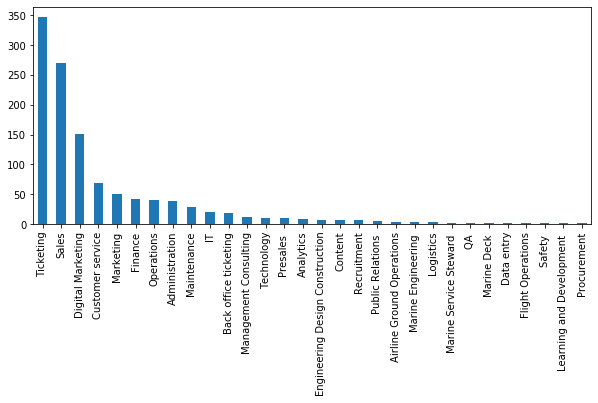

In [5]:
plt.figure(figsize=(10,4))
departments = df.Department.unique()
df['Department'].value_counts().plot(kind='bar');

The classes are not well balanced

In [6]:
list1 = []

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

for i in glob.glob('data/docs/*.json'):
    file = json.load(open(i))
    desc = file['jd_information']['description']
    desc = REPLACE_BY_SPACE_RE.sub(' ', desc.lower())
#     desc = BAD_SYMBOLS_RE.sub(' ', desc)
    desc = desc.split()
                    
    list1.append([int(file['_id']), file['jd_information']['description'], desc])
    
desc_df = pd.DataFrame(list1, columns=['Document ID', 'Description', 'Filtered'])

In [7]:
final_df = pd.merge(df, desc_df, left_on='Document ID', right_on='Document ID')
final_df.head()

,Document ID,Department,Description,Filtered
0,8196431,Customer service,Designation- TeleMarketing ExecutiveKeyskills-...,"[designation-, telemarketing, executivekeyskil..."
1,8278123,Digital Marketing,We need committed &amp; result-oriented people...,"[we, need, committed, &amp, result-oriented, p..."
2,8331625,Sales,Greetings from Akkam Immigrations!!!Immediate ...,"[greetings, from, akkam, immigrations!!!immedi..."
3,8331003,Back office ticketing,"Dear Candidates,Greetings From Continental Imm...","[dear, candidates, greetings, from, continenta..."
4,8277939,Digital Marketing,We need committed &amp; result-oriented people...,"[we, need, committed, &amp, result-oriented, p..."


In [8]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [9]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer, important for a parameter of the model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [10]:
#BUILD_VOCAB()
w2v_model.build_vocab(final_df["Filtered"], progress_per=1000)

#TRAIN()
w2v_model.train(final_df['Filtered'], total_examples=w2v_model.corpus_count, epochs=10000, report_delay=1)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-a8edba1b34fa>", line 5, in <module>
    w2v_model.train(final_df['Filtered'], total_examples=w2v_model.corpus_count, epochs=10000, report_delay=1)
  File "/home/iso-2/.local/lib/python3.6/site-packages/gensim/models/word2vec.py", line 910, in train
    queue_factor=queue_factor, report_delay=report_delay, compute_loss=compute_loss, callbacks=callbacks)
  File "/home/iso-2/.local/lib/python3.6/site-packages/gensim/models/base_any2vec.py", line 1081, in train
    **kwargs)
  File "/home/iso-2/.local/lib/python3.6/site-packages/gensim/models/base_any2vec.py", line 553, in train
    total_words=total_words, queue_factor=queue_factor, report_delay=report_delay)
  File "/home/iso-2/.local/lib/python3.6/site-packages/gensim/models/base_any2vec.py", line 489, in _train_epoch
  

KeyboardInterrupt: 

In [147]:
final_df.head()

,Document ID,Department,Description,Filtered
0,8196431,Customer service,Designation- TeleMarketing ExecutiveKeyskills-...,designation- telemarketing executivekeyskills-...
1,8278123,Digital Marketing,We need committed &amp; result-oriented people...,we need committed &amp result-oriented people ...
2,8331625,Sales,Greetings from Akkam Immigrations!!!Immediate ...,greetings from akkam immigrations!!!immediate ...
3,8331003,Back office ticketing,"Dear Candidates,Greetings From Continental Imm...",dear candidates greetings from continental imm...
4,8277939,Digital Marketing,We need committed &amp; result-oriented people...,we need committed &amp result-oriented people ...


In [3]:
#words similar to good
w2v_model.wv.most_similar(positive=["data"])

NameError: name 'w2v_model' is not defined

In [173]:
y = final_df['Department'].values
X = np.array(final_df['Filtered'])

#And here is the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [174]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 694


In [178]:
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix

In [190]:
# def plot_word_cloud(terms):
#     text = terms.index
#     text = ' '.join(list(text))
#     # lower max_font_size
#     wordcloud = WordCloud(max_font_size=40).generate(text)
#     plt.figure(figsize=(25, 25))
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()
# tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
# tfidf2.columns = ['tfidf']
# plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True).head(100))

In [180]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [182]:
from sklearn.preprocessing import scale

In [183]:
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scale(test_vecs_w2v)

print ('shape for training set : ',train_vecs_w2v.shape,
      '\nshape for test set : ', test_vecs_w2v.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



shape for training set :  (929, 300) 
shape for test set :  (233, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [187]:
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate

Using TensorFlow backend.
/home/iso-2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/iso-2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/iso-2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/iso-2/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

In [188]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=300))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               38528     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 38,657
Trainable params: 38,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_train)])
train_vecs_w2v = scale(train_vecs_w2v)

In [198]:
history = model.fit(train_vecs_w2v, y_train, epochs=20, batch_size=50,
                   validation_data=(test_vecs_w2v,y_test))
loss, accuracy = model.evaluate(train_vecs_w2v, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_vecs_w2v, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 929 samples, validate on 233 samples
Epoch 1/20


ValueError: could not convert string to float: 'Ticketing'